# Rethinking link prediction 

The widely accepted link prediction benchmark is inadequate for assessing the precision of link prediction models, which is critical in applications, e.g., a low-precision recommendation system provides many false recommendations, hurting user experience. The inadequacy is attributed to two factors. First, the evaluation metric (AUC-ROC) neglects the practical importance of high-scoring predictions. Second, many false high-scoring predictions are omitted from the evaluation by the sampling of unconnected node pairs. The results presented in this notebook will demonstrate the limitations of current link prediction benchmark (and hopefully to provide some remedies).

## What is link prediction? And why it's important?

- Link prediction for networks is the task of predicting the connections between pairs of nodes in a network. 
- Link prediction has many application, such as recommendation systems, fraud detection, and knowledge discoveries. 
- Additionally, link prediction can be used to test hypotheses about network generation models, and successful link prediction provides insights into the underlying mechanisms that shape network structure. 

## Prevailing link prediction benchmark 

- A link prediction algorithm is evaluated based on its ability to predict missing edges that are actually present but not observed in a given network. 
- To test this, the algorithm is given a training network with missing edges and is required to provide a prediction score $s_{ij}$ for each pair of nodes $i$ and $j$. The higher the score, the greater the likelihood of an edge existing between those two nodes.
- Since there are significantly more unconnected nodes than missing edges due to edge sparsity, a subset of unconnected node pairs sampled uniformly at random is used, with the same size as the set of missing edges.
- The algorithm is deemed to be a successful link prediction algorithm if the score is higher for the missing edges (green in the figure below) than for the unconnected node pairs (red).
- The overlap of the distributions for the missing edges and unconnected node pairs is commonly quantified by the area under curve (AUC) of the receiving operator characteristics (ROC; right panel).


![](https://hrngok.github.io/images/roc10.jpg)


## Issue of the prevailing benchmark

Let us demonstrate the issue discussed above. We will use link prediction based on the preferential attachment, which gives the prediction score by   
$$
\begin{align}
s_{ij} = \log(d_i)  + \log(d_j),
\end{align}
$$ 
where $d_i$ is the degree of node $i$. We assume that the network is undirected and unweighted. For the network, we use the following network: 

In [1]:
network_name = "polblog"
net_file_path = (
    f"../../test_data/derived/networks/raw/{network_name}/edge_table.csv"
    # f"../../mydata/derived/networks/preprocessed/{network_name}/edge_table.csv"
)

Networks

Let's import libraries and generate the dataset for link prediction:

In [2]:
from scipy import sparse
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# In-house
from linkpred.LinkPredictionDataset import LinkPredictionDataset
import embcom
import utils
import networkx as nx

/home/skojaku/anaconda3/envs/linkpred/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Ignore this message if you do not use Glove. Otherwise, install glove python package by 'pip install glove_python_binary' 


2023-04-30 14:27:48.951205: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-30 14:27:48.951431: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 14:27:48.954584: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Load the network

In [3]:
edge_table = pd.read_csv(net_file_path, dtype={"src": int, "trg": int})
net = utils.edge2network(src=edge_table["src"], trg=edge_table["trg"])
net.setdiag(0)
net.eliminate_zeros()
net.data = net.data * 0 + 1

/home/skojaku/anaconda3/envs/linkpred/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Here is how the network looks like:

In [5]:
G = nx.from_scipy_sparse_array(net)
# Layout
pos = nx.layout.kamada_kawai_layout(G)
xys = np.vstack([p for p in pos.values()])
deg = np.array(net.sum(axis=1)).reshape(-1)

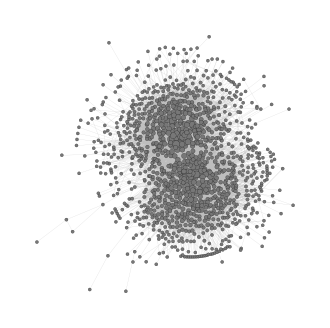

In [6]:
# Plot
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(4, 4))

nx.draw_networkx_edges(
    G,
    pos,
    edge_color="#bdbdbd",
    width=0.1,
    ax=ax,
)
sns.scatterplot(
    x=xys[:, 0],
    y=xys[:, 1],
    size=deg,
    sizes=(5, 40),
    color="#777",
    edgecolor="k",
    ax=ax,
)
# ax.axis("off")
ax.legend().remove()
ax.axis("off")
fig.savefig("network.pdf", bbox_inches="tight", dpi=300)

In [4]:
# Construct the link prediction benchmark
lpmodel = LinkPredictionDataset(
    testEdgeFraction=0.5, negative_edge_sampler="uniform", all_negatives=True
)
lpmodel.fit(net)
train_net, test_edge_table = lpmodel.transform()

# To ensure that the network is undirected and unweighted
train_net = utils.toUndirected(train_net)

# src_test, trg_test, y = test_edge_table["src"].values, test_edge_table["trg"].values, test_edge_table["isPositiveEdge"].values
display(test_edge_table.groupby("isPositiveEdge").head(3))
print(
    f"Fraction of connected node pairs in the test edge set: %.3f"
    % test_edge_table["isPositiveEdge"].mean()
)

,src,trg,isPositiveEdge
0,126,801,1
1,1,187,1
2,3,201,1
8357,0,17,0
8358,0,18,0
8359,0,19,0


Fraction of connected node pairs in the test edge set: 0.011


- The `test_edge_table` contains pairs of node IDs, and the `isPositiveEdge` flag indicates whether there is an edge between the two nodes; a value of one indicates that there is an edge, and a value of zero indicates that there is not. This table contains *all* unconnected node pairs, which will be sampled. 
- `train_net` is the training network consists of edges that are observed for the algorithm to be tested.


Let us calculate the prediction score based on the preferential attachment:

In [5]:
deg = np.array(train_net.sum(axis=1)).reshape(-1)
log_deg = np.log(np.maximum(deg, 1))
S = np.add.outer(log_deg, log_deg)

Now, let's compare the prediction score for the missing edges and unconnected node pairs. 

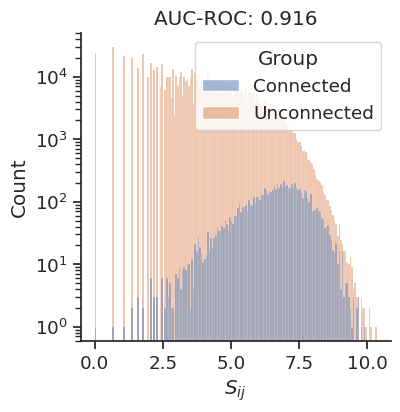

In [6]:
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(4, 4))

src_test, trg_test, y = tuple(test_edge_table.values.T)
ypred = S[(src_test, trg_test)]
aucroc = roc_auc_score(y, ypred)

df = pd.DataFrame(
    {"Group": map(lambda x: ["Unconnected", "Connected"][x], y), "Sij": ypred}
)
ax = sns.histplot(data=df, x="Sij", hue="Group", common_norm=False, stat="count", ax=ax)
ax.set_xlabel(r"$S_{ij}$")
ax.set_yscale("log")
ax.set_title(f"AUC-ROC: {aucroc:.3f}")
sns.despine()

It's impressive AUC-ROC score. Indeed, the preferential attachment achieves surprisingly (and spuriously) high AUC-ROC score given its simple formula.  Now, let's zoom in the area, where prediction score $s_{ij}$ is high. This time, we take the count as the y-axis instead of the probability:  

Sort the link prediction by Sij


,Group,Sij
12908,Unconnected,10.338900
137076,Unconnected,10.156578
10814,Unconnected,10.074748
12819,Unconnected,10.065606
19418,Unconnected,9.985620
12851,Unconnected,9.927985
23749,Unconnected,9.897067
1386,Connected,9.894649
111732,Unconnected,9.859327
13057,Unconnected,9.824444


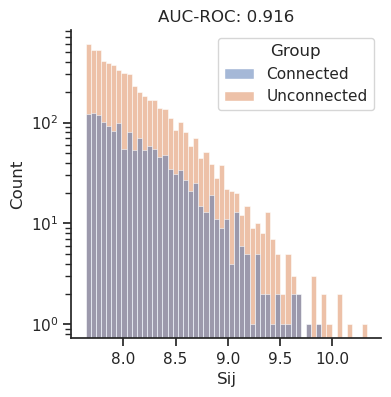

In [7]:
sns.set_style("white")
sns.set(font_scale=1)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(4, 4))

src_test, trg_test, y = tuple(test_edge_table.values.T)
ypred = S[(src_test, trg_test)]
aucroc = roc_auc_score(y, ypred)

df = pd.DataFrame(
    {
        "Group": map(lambda x: ["Unconnected", "Connected"][x], y),
        "Sij": ypred,
    }
)
s = np.quantile(df["Sij"], 0.99)
df = df[df["Sij"] >= s]
ax = sns.histplot(
    data=df,
    x="Sij",
    hue="Group",
    common_norm=False,
    stat="count",
    hue_order=["Connected", "Unconnected"],
    ax=ax,
)
ax.set_yscale("log")
ax.set_title(f"AUC-ROC: {aucroc:.3f}")
# ax.legend(frameon=False, fontsize=12, labels = ["Connected", "Unconnected"])
sns.despine()
print("Sort the link prediction by Sij")
df.sort_values(by="Sij", ascending=False).head(10)

The right-tail of the distributions provide a critical observation: preferential attachment incorrectly predicted the edges with the highest scores. In fact, as we go through from the highest to lowest scoring link prediction, the preferential attachment made the first correct prediction after failing eight predictions. Discuss the implication for information retrieval. 

The result provides a practical implication: preferential attachment is not a reliable link prediction method. This could be a major issue for recommendation systems because making many false predictions may harm user experience.

To be worse, most false predictions are unlikely to be counted in the prevailing benchmark because of the sampling of unconnected node pairs. To see this, let us randomly sample the unconnected node pairs, with the same size as the positive edges by following the accepted practice.

In [8]:
n_positives = int(test_edge_table["isPositiveEdge"].sum())
sampled_test_edge_table = (
    test_edge_table.sample(frac=1).groupby("isPositiveEdge").head(n_positives)
)
print(
    f"Fraction of connected node pairs in the test edge set: %.2f"
    % sampled_test_edge_table["isPositiveEdge"].mean()
)

Fraction of connected node pairs in the test edge set: 0.50


Second, let's see the distribution of the prediction score:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


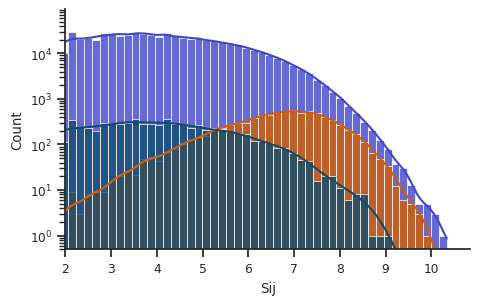

In [9]:
sns.set_style("white")
sns.set(font_scale=0.8)
sns.set_style("ticks")
fig, axes = plt.subplots(
    figsize=(6, 3)
)

hue_order = ["Sampled negative edges", "Test edges", "All negative edges"]
cmap = sns.color_palette("colorblind")
cmap = {
    "Test edges": cmap[3],# "#ff0000",  # "#0fb5ae",#cmap[1],
    "Sampled negative edges": sns.dark_palette(cmap[0], n_colors=5)[2],  # "#0fb5ae",#cmap[1],
    "All negative edges":"#4046ca", #sns.dark_palette(cmap[0], n_colors=5)[4],  # cmap[2],
}

#
# All 
#
src_test, trg_test, y = tuple(test_edge_table.values.T)
ypred = S[(src_test, trg_test)]
aucroc = roc_auc_score(y, ypred)

src_neg_subset, trg_neg_subset, ysub = tuple(sampled_test_edge_table.values.T)
s = ysub == 0
src_neg_subset, trg_neg_subset = src_neg_subset[s], trg_neg_subset[s]

src_test, trg_test, y = np.concatenate([src_test, src_neg_subset]), np.concatenate([trg_test, trg_neg_subset]),np.concatenate([(y + 1), np.zeros_like(src_neg_subset)])
ypred = S[(src_test, trg_test)]

df = pd.DataFrame(
    {"Group": map(lambda x: ["Sampled negative edges","All negative edges", "Test edges"][x], y), "Sij": ypred}
)
s = np.quantile(df["Sij"], 0.99)

ax = sns.histplot(
    data=df,
    x="Sij",
    common_norm=False,
    bins = 60,
    stat="count",
    palette=cmap,
    edgecolor = "#ffffffff",
    hue="Group",
    hue_order=hue_order,
    kde=True,
    alpha = 0.8,
    ax=axes,
)
ax.set_yscale("log")
ax.set_xlim(2,)
ax.set_ylim(5e-1,)
ax.legend().remove()
# Set the subplots to overlap
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=1, wspace=0.5)
# Remove axes details that don't play well with overlap
sns.despine()
fig.savefig("score-pref-attachment.pdf")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


,Group,Sij
12908,All negative edges,10.338900
137076,All negative edges,10.156578
10814,All negative edges,10.074748
12819,All negative edges,10.065606
19418,All negative edges,9.985620
12851,All negative edges,9.927985
23749,All negative edges,9.897067
1386,Test edges,9.894649
111732,All negative edges,9.859327
13057,All negative edges,9.824444


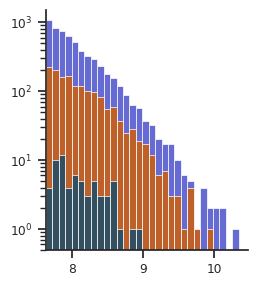

In [10]:
sns.set_style("white")
sns.set(font_scale=0.8)
sns.set_style("ticks")
fig, axes = plt.subplots(
    figsize=(3, 3)
)

#
# All 
#
src_test, trg_test, y = tuple(test_edge_table.values.T)
ypred = S[(src_test, trg_test)]
aucroc = roc_auc_score(y, ypred)

src_neg_subset, trg_neg_subset, ysub = tuple(sampled_test_edge_table.values.T)
s = ysub == 0
src_neg_subset, trg_neg_subset = src_neg_subset[s], trg_neg_subset[s]

src_test, trg_test, y = np.concatenate([src_test, src_neg_subset]), np.concatenate([trg_test, trg_neg_subset]),np.concatenate([(y + 1), np.zeros_like(src_neg_subset)])
ypred = S[(src_test, trg_test)]

df = pd.DataFrame(
    {"Group": map(lambda x: ["Sampled negative edges","All negative edges", "Test edges"][x], y), "Sij": ypred}
)
s = np.quantile(df["Sij"], 0.99)
df = df[df["Sij"]>s]

ax = sns.histplot(
    data=df,
    x="Sij",
    common_norm=False,
    bins = 30,
    stat="count",
    palette=cmap,
    edgecolor = "#ffffffff",
    hue="Group",
    hue_order=hue_order,
    kde=False,
    alpha = 0.8,
    ax=axes
)
ax.set_yscale("log")
ax.set_xlim(s,)
ax.set_ylim(5e-1,)
ax.legend().remove()
ax.set_xlabel("")
ax.set_ylabel("")
# Set the subplots to overlap
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=1, wspace=0.5)
# Remove axes details that don't play well with overlap
sns.despine()
fig.savefig("score-pref-attachment-inset.pdf")
df.sort_values(by="Sij", ascending=False).head(10)

Most high-scoring unconnected node pairs disappear, since they make up a small portion of all unconnected node pairs and therefore are unlikely to be chosen for evaluation.

Now, let's consider another more sophisticated prediction algorithm: the graph convolution network (GCN). We use GCN to learn a vector representation of nodes and compute the prediction score $s_{ij}$ by the dot-similarity of two nodes.  

In [20]:
# Learning embedding
emb = utils.embedding_models["line"](train_net, dim=64, num_walks=3)
# emb = utils.embedding_models["GCN"](train_net, dim = 64, device = "cuda:0")

# making prediction by the dot-similarity
S = emb @ emb.T

The distributions of prediction scores for the missing and unconnected node pairs:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


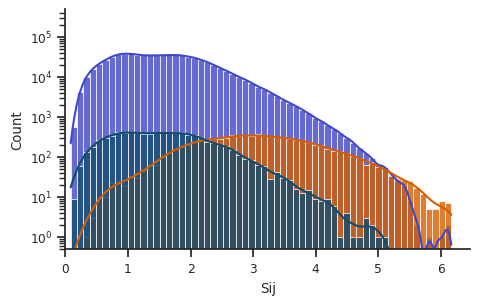

In [23]:
sns.set_style("white")
sns.set(font_scale=0.8)
sns.set_style("ticks")

fig, axes = plt.subplots(
    figsize=(6, 3)
)

hue_order = ["Sampled negative edges", "Test edges", "All negative edges"]
cmap = sns.color_palette("colorblind")
cmap = {
    "Test edges": cmap[3],# "#ff0000",  # "#0fb5ae",#cmap[1],
    "Sampled negative edges": sns.dark_palette(cmap[0], n_colors=5)[2],  # "#0fb5ae",#cmap[1],
    "All negative edges":"#4046ca", #sns.dark_palette(cmap[0], n_colors=5)[4],  # cmap[2],
}

#
# All 
#
src_test, trg_test, y = tuple(test_edge_table.values.T)
ypred = S[(src_test, trg_test)]
aucroc = roc_auc_score(y, ypred)

src_neg_subset, trg_neg_subset, ysub = tuple(sampled_test_edge_table.values.T)
s = ysub == 0
src_neg_subset, trg_neg_subset = src_neg_subset[s], trg_neg_subset[s]

src_test, trg_test, y = np.concatenate([src_test, src_neg_subset]), np.concatenate([trg_test, trg_neg_subset]),np.concatenate([(y + 1), np.zeros_like(src_neg_subset)])
ypred = S[(src_test, trg_test)]

df = pd.DataFrame(
    {"Group": map(lambda x: ["Sampled negative edges","All negative edges", "Test edges"][x], y), "Sij": ypred}
)
s = np.quantile(df["Sij"], 0.99)

ax = sns.histplot(
    data=df,
    x="Sij",
    common_norm=False,
    bins = 60,
    stat="count",
    palette=cmap,
    edgecolor = "#ffffffff",
    hue="Group",
    hue_order=hue_order,
    kde=True,
    alpha = 0.8,
    ax=axes,
)
ax.set_yscale("log")
ax.set_xlim(0,)
ax.set_ylim(5e-1,)
ax.legend().remove()
# Set the subplots to overlap
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=1, wspace=0.5)
# Remove axes details that don't play well with overlap
sns.despine()
fig.savefig("score-line.pdf")

Notice that the AUC-ROC score is *lower* than the preferential attachment. And thus, with the current link prediction benchmark, GCN is not deemed as a better prediction method. Or is it? Let's zoom in the right-tail of the distribution to see the top-scoring predictions.  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


,Group,Sij
3960,Test edges,6.298723
2479,Test edges,6.281739
5910,Test edges,6.277630
5262,Test edges,6.274132
6680,Test edges,6.238276
436,Test edges,6.235826
113712,All negative edges,6.187784
2017,Test edges,6.183671
171487,All negative edges,6.182259
2265,Test edges,6.181044


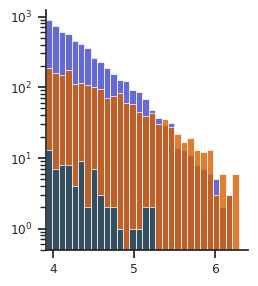

In [13]:
sns.set_style("white")
sns.set(font_scale=0.8)
sns.set_style("ticks")
fig, axes = plt.subplots(
    figsize=(3, 3)
)

#
# All 
#
src_test, trg_test, y = tuple(test_edge_table.values.T)
ypred = S[(src_test, trg_test)]
aucroc = roc_auc_score(y, ypred)

src_neg_subset, trg_neg_subset, ysub = tuple(sampled_test_edge_table.values.T)
s = ysub == 0
src_neg_subset, trg_neg_subset = src_neg_subset[s], trg_neg_subset[s]

src_test, trg_test, y = np.concatenate([src_test, src_neg_subset]), np.concatenate([trg_test, trg_neg_subset]),np.concatenate([(y + 1), np.zeros_like(src_neg_subset)])
ypred = S[(src_test, trg_test)]

df = pd.DataFrame(
    {"Group": map(lambda x: ["Sampled negative edges","All negative edges", "Test edges"][x], y), "Sij": ypred}
)
s = np.quantile(df["Sij"], 0.99)
df = df[df["Sij"]>s]

ax = sns.histplot(
    data=df,
    x="Sij",
    common_norm=False,
    bins = 30,
    stat="count",
    palette=cmap,
    edgecolor = "#ffffffff",
    hue="Group",
    hue_order=hue_order,
    kde=False,
    alpha = 0.8,
    ax=axes
)
ax.set_yscale("log")
ax.set_xlim(s,)
ax.set_ylim(5e-1,)
ax.legend().remove()
ax.set_xlabel("")
ax.set_ylabel("")
# Set the subplots to overlap
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=1, wspace=0.5)
# Remove axes details that don't play well with overlap
sns.despine()

fig.savefig("score-line-inset.pdf")
df.sort_values(by="Sij", ascending=False).head(10)

Although GCN failed for its highest-scoring prediction, it accurately predicted six missing edges among the top 9 prediction, which is six times better than the preferential attachment in terms of precision. In other words, GCN provides more reliable prediction with much higher precision than preferential attachment. 

As is seen for the preferential attachment, sampling the unconnected node pairs leads to a spuriously better picture: 

Sort the link prediction by Sij


,Group,Sij
8984,Connected,1.840347
11112,Connected,1.837647
9527,Connected,1.836992
12781,Connected,1.836435
13579,Connected,1.830704
16164,Connected,1.830311
9448,Connected,1.821912
10818,Connected,1.821487
16440,Connected,1.820747
11458,Connected,1.812784


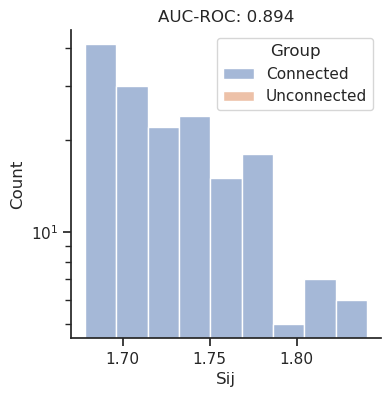

In [14]:
sns.set_style("white")
sns.set(font_scale=1)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(4, 4))

src_test, trg_test, y = tuple(sampled_test_edge_table.values.T)
ypred = S[(src_test, trg_test)]
aucroc = roc_auc_score(y, ypred)

df = pd.DataFrame(
    {
        "Group": map(lambda x: ["Unconnected", "Connected"][x], y),
        "Sij": np.log(np.maximum(ypred, 1)),
    }
)
s = np.quantile(df["Sij"], 0.99)
df = df[df["Sij"] >= s]
ax = sns.histplot(
    data=df,
    x="Sij",
    hue="Group",
    common_norm=False,
    stat="count",
    hue_order=["Connected", "Unconnected"],
    ax=ax,
)
ax.set_yscale("log")
ax.set_title(f"AUC-ROC: {aucroc:.3f}")
# ax.legend(frameon=False, fontsize=12, labels = ["Connected", "Unconnected"])
sns.despine()
print("Sort the link prediction by Sij")
df.sort_values(by="Sij", ascending=False).head(10)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


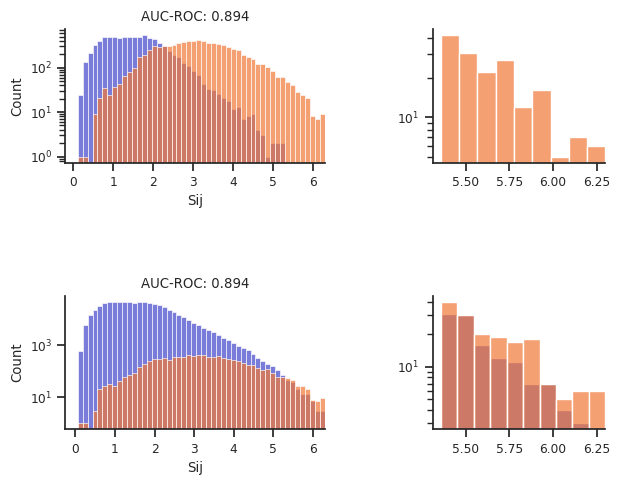

In [15]:
sns.set_style("white")
sns.set(font_scale=0.8)
sns.set_style("ticks")
fig, axes = plt.subplots(
    figsize=(8, 5), nrows=2, ncols=2, gridspec_kw={"width_ratios": [1.5, 1]}
)

hue_order = ["Unconnected", "Connected"][::-1]
cmap = sns.color_palette("Set2")
cmap = {
    "Connected": "#f07837",  # "#0fb5ae",#cmap[1],
    "Unconnected": "#4046ca",  # cmap[2],
}

#
# Subset
#
src_test, trg_test, y = tuple(sampled_test_edge_table.values.T)
ypred = S[(src_test, trg_test)]
aucroc = roc_auc_score(y, ypred)

df = pd.DataFrame(
    {"Group": map(lambda x: ["Unconnected", "Connected"][x], y), "Sij": ypred}
)
s = np.quantile(df["Sij"], 0.99)
ax = sns.histplot(
    data=df,
    x="Sij",
    common_norm=False,
    stat="count",
    bins = 50,
    ax=axes[0, 0],
    palette=cmap,
    hue="Group",
    alpha=0.7,
    hue_order=hue_order,
)
ax.set_yscale("log")
ax.legend().remove()

dg = df[df["Sij"] >= s]
ax = sns.histplot(
    data=dg,
    x="Sij",
    common_norm=False,
    stat="count",
    ax=axes[0, 1],
    palette=cmap,
    hue="Group",
    alpha=0.7,
    hue_order=hue_order,
)
ax.set_yscale("log")
ax.legend().remove()
ax.set_xlabel("")
ax.set_ylabel("")

axes[0, 0].set_title(f"AUC-ROC: {aucroc:.3f}")

#
# Full set
#
src_test, trg_test, y = tuple(test_edge_table.values.T)
ypred = S[(src_test, trg_test)]
aucroc = roc_auc_score(y, ypred)

df = pd.DataFrame(
    {"Group": map(lambda x: ["Unconnected", "Connected"][x], y), "Sij": ypred}
)
ax = sns.histplot(
    data=df,
    x="Sij",
    common_norm=False,
    bins = 50,
    stat="count",
    ax=axes[1, 0],
    palette=cmap,
    hue="Group",
    alpha = 0.7,
    hue_order=hue_order,
)
ax.set_yscale("log")
ax.legend().remove()

dg = df[df["Sij"] >= s]
ax = sns.histplot(
    data=dg,
    x="Sij",
    common_norm=False,
    stat="count",
    ax=axes[1, 1],
    palette=cmap,
    hue="Group",
    alpha=0.7,
    hue_order=hue_order,
)
ax.set_yscale("log")
ax.legend().remove()
ax.set_xlabel("")
ax.set_ylabel("")
axes[1, 0].set_title(f"AUC-ROC: {aucroc:.3f}")

# ax.set_xlabel(r"$S_{ij}$")
xmax = df["Sij"].max()
axes[0,0].set_xlim(None, xmax)
axes[1,0].set_xlim(None, xmax)
axes[0,1].set_xlim(None, xmax)
axes[1,1].set_xlim(None, xmax)
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=1, wspace=0.5)
sns.despine()
fig.savefig("score-line.pdf")

# New link prediction benchmarks

### From classification to ranking  
To focus on the top-scoring predictions, I propose evaluating algorithms based on link *ranking* rather than link *classifications*. This is because ranking reflects the ordering of predictions, while classification does not. More specifically, I propose the following benchmark:
1. Divide a given network into the train and test edge set. 
2. Find the top-scoring predictions by the test algorithm and add to the test edge set. Do so such that the numbers of connected and unconnected node pairs are equal in the test edge set.  
3. Use the AUC of the precision-recall curve (a.k.a average precision), instead of AUC of the ROC.

Let's reevaluate the algorithms, together with other algorithms with the proposed benchmark. 

In [52]:
PredScore = {}
for model_name, pred_model in tqdm(utils.embedding_models.items()):
    emb = pred_model(train_net, dim=64)
    PredScore[model_name] = emb @ emb.T

for model_name, pred_model in tqdm(utils.topology_models.items()):
    src, trg = np.triu_indices(train_net.shape[0], k=1)
    score = pred_model(train_net, src, trg)
    S = np.zeros(net.shape)
    S[(src, trg)] = score
    PredScore[model_name] = S + S.T

 62%|██████▎   | 5/8 [02:44<01:38, 32.97s/it]


KeyboardInterrupt: 

Evaluation by classification

In [ ]:
# y = 1 for existent edges. y = 0 for non-existent edges.
src_test, trg_test, y = tuple(test_edge_table.values.T)
ypos, src_pos, trg_pos = y[y > 0], src_test[y > 0], trg_test[y > 0]
yneg, src_neg, trg_neg = y[y == 0], src_test[y == 0], trg_test[y == 0]

# Evaluation
results = []
n_positives = int(np.sum(y))
for model_name, S in PredScore.items():
    ypred_pos = S[(src_pos, trg_pos)]
    ypred_neg = S[(src_neg, trg_neg)]

    #
    # Existing link prediction benchmark
    #
    _y = np.concatenate([ypos, np.zeros(n_positives)]).astype(int)
    # Random sampling of negative node piars
    _ypred_neg = np.random.choice(ypred_neg, size=n_positives)
    _ypred = np.concatenate([ypred_pos, _ypred_neg])
    aucroc = roc_auc_score(_y, _ypred)
    results += [
        {
            "metric": "AUC-ROC",
            "score": aucroc,
            "Model": model_name,
            "benchmarkType": "classification",
        }
    ]

    # Explore different metrics
    # (Precision)
    average_precision = average_precision_score(_y, _ypred)
    results += [
        {
            "metric": "Average precision",
            "score": average_precision,
            "Model": model_name,
            "benchmarkType": "classification",
        }
    ]

    #
    # Proposed link prediction benchmark
    #
    # Pick the highest-scoring predictions
    _ypred_neg = np.sort(ypred_neg)[::-1][:n_positives]
    _ypred = np.concatenate([ypred_pos, _ypred_neg])
    average_precision = average_precision_score(_y, _ypred)
    results += [
        {
            "metric": "Average Precision",
            "score": average_precision,
            "Model": model_name,
            "benchmarkType": "ranking",
        }
    ]

    # Explore different metrics
    # (AUCROC)
    aucroc = roc_auc_score(_y, _ypred)
    results += [
        {
            "metric": "AUC-ROC",
            "score": aucroc,
            "Model": model_name,
            "benchmarkType": "ranking",
        }
    ]
result_table = pd.DataFrame(results)
result_table

,metric,score,Model,benchmarkType
0,AUC-ROC,0.831802,line,classification
1,Average precision,0.824579,line,classification
2,Average Precision,0.315506,line,ranking
3,AUC-ROC,0.070232,line,ranking
4,AUC-ROC,0.665264,node2vec,classification
5,Average precision,0.572724,node2vec,classification
6,Average Precision,0.306954,node2vec,ranking
7,AUC-ROC,0.002245,node2vec,ranking
8,AUC-ROC,0.659728,deepwalk,classification
9,Average precision,0.566414,deepwalk,classification


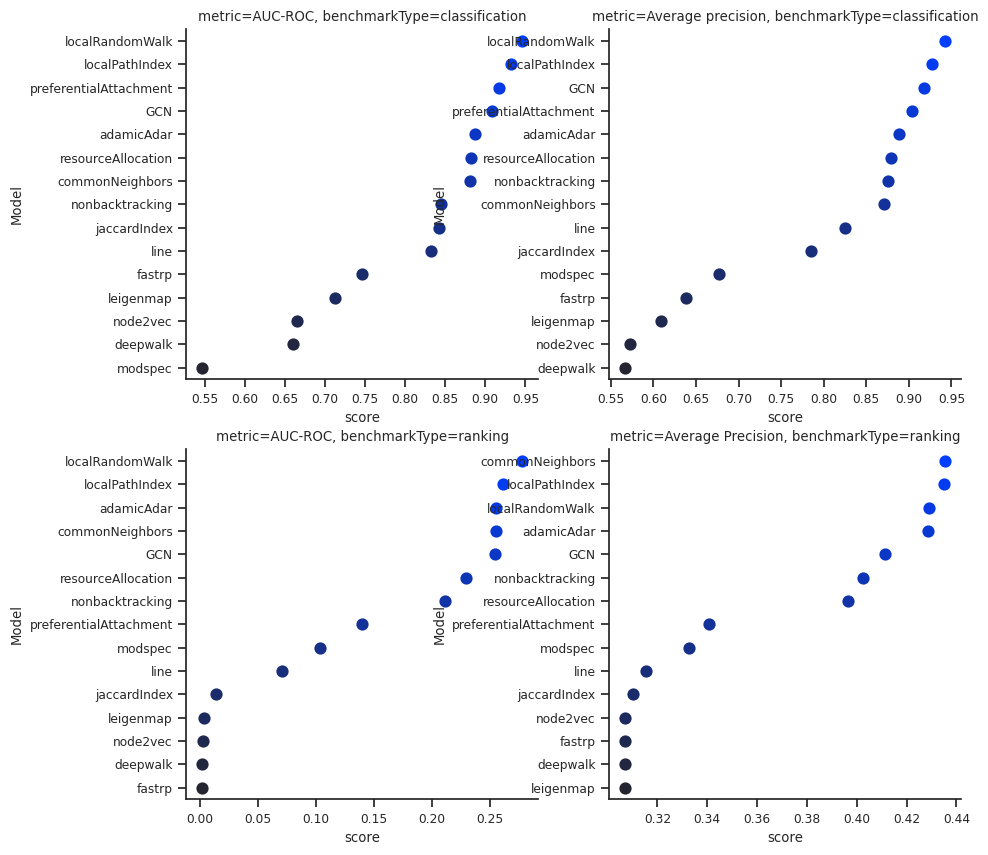

In [ ]:
sns.set_style("white")
sns.set(font_scale=0.8)
sns.set_style("ticks")
fig, axes = plt.subplots(figsize=(5 * 2, 5 * 2), ncols=2, nrows=2)


for row_id, (benchmarkType, df) in enumerate(result_table.groupby("benchmarkType")):
    for col_id, (metric, dg) in enumerate(df.groupby("metric")):
        ax = sns.pointplot(
            data=dg.sort_values(by="score", ascending=False),
            x="score",
            y="Model",
            hue="score",
            color=sns.color_palette("bright")[0],
            join=False,
            ax=axes[row_id, col_id],
        )
        ax.set_title(f"metric={metric}, benchmarkType={benchmarkType}")
        ax.legend().remove()
# ax.set_xlim(0.5, 1.0)

sns.despine()
# fig.savefig(output_file, bbox_inches='tight', dpi=300)

Evaluation based on ranking 

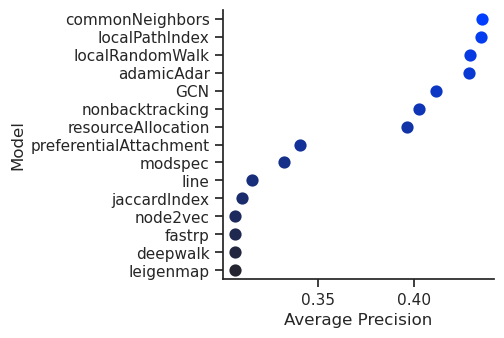

In [ ]:
sns.set_style("white")
sns.set(font_scale=1)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax = sns.pointplot(
    data=result_ranking_table.sort_values(by="Average Precision", ascending=False),
    x="Average Precision",
    y="Model",
    hue="Average Precision",
    color=sns.color_palette("bright")[0],
    join=False,
)
ax.legend().remove()
sns.despine()

The results presented in this notebook serves as a warning that the current link prediction benchmark fails to accurately measure the precision of different link prediction models. This inadequacy is attributed to two factors: 
1. High-scoring predictions are more important than low-scoring prediction in applications, although they have a little impact on AUC-ROC, as it reflects the overall accuracy of prediction. 
2. Sampling unconnected node pairs removes many false high-scoring predictions, making it challenging to assess the precision of link prediction. 
